Data sourced from: https://archive.ics.uci.edu/dataset/222/bank+marketing

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_selection import RFE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, power_transform
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

sns.set_theme(style="darkgrid")

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Exploratory Data Analysis

In [44]:
# --- Read in data
 
data = pd.read_csv('data/bank-additional-full.csv',sep=";")

df = data.copy()
df.sample(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
20110,50,admin.,married,basic.4y,unknown,yes,no,cellular,aug,mon,...,2,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,no
29749,32,admin.,single,university.degree,no,yes,no,cellular,apr,mon,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,no
38102,43,self-employed,married,high.school,no,yes,no,cellular,sep,thu,...,1,999,0,nonexistent,-3.4,92.379,-29.8,0.766,5017.5,no
10297,36,technician,married,university.degree,no,no,no,telephone,jun,mon,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.960,5228.1,yes
26664,32,technician,married,university.degree,no,no,yes,cellular,nov,thu,...,2,999,0,nonexistent,-0.1,93.200,-42.0,4.076,5195.8,no


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [46]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [47]:
# --- Changing column names for better interpretability

col_name_change = {
    'job' : 'job_category',
    'marital' : 'marital_status',
    'default' : 'history_of_default',
    'housing' : 'has_housing_loan',
    'loan' : 'has_personal_loan',
    'contact' : 'contact_type',
    'month' : 'month_of_last_contact',
    'day_of_week' : 'dayofweek_of_last_contact',
    'campaign' : 'no_of_previous_campaigns',
    'pdays' : 'days_since_last_contact',
    'previous' : 'number_of_times_contacted',
    'poutcome' : 'outcome_of_previous_campaign',
    'y' : 'conversion'
}

df = df.rename(columns=col_name_change)
df.drop('conversion', axis=1).columns

Index(['age', 'job_category', 'marital_status', 'education',
       'history_of_default', 'has_housing_loan', 'has_personal_loan',
       'contact_type', 'month_of_last_contact', 'dayofweek_of_last_contact',
       'duration', 'no_of_previous_campaigns', 'days_since_last_contact',
       'number_of_times_contacted', 'outcome_of_previous_campaign',
       'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m',
       'nr.employed'],
      dtype='object')

d:\Projects\lead_scoring\.venv\lib\site-packages\seaborn\axisgrid.py:447: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


<Figure size 640x480 with 0 Axes>

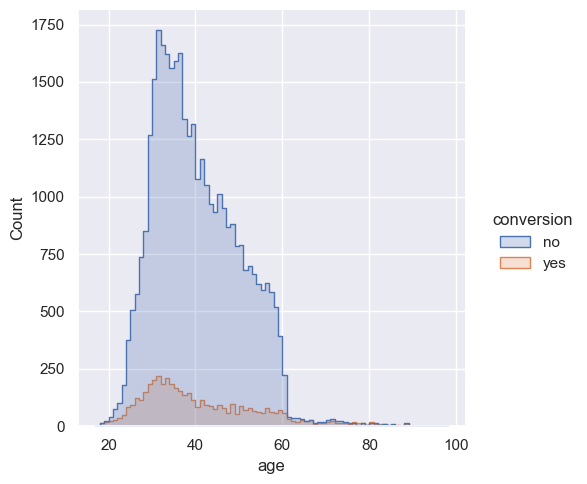

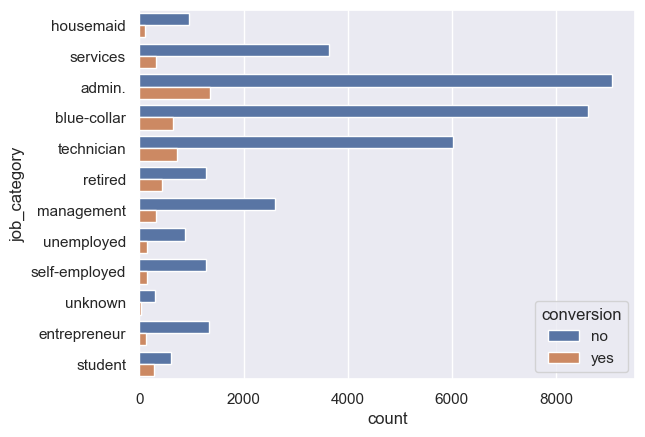

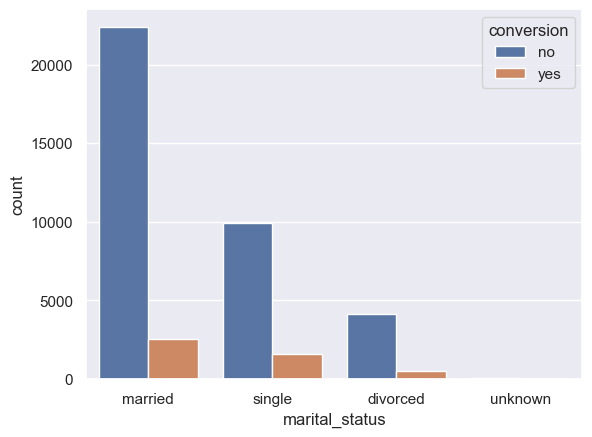

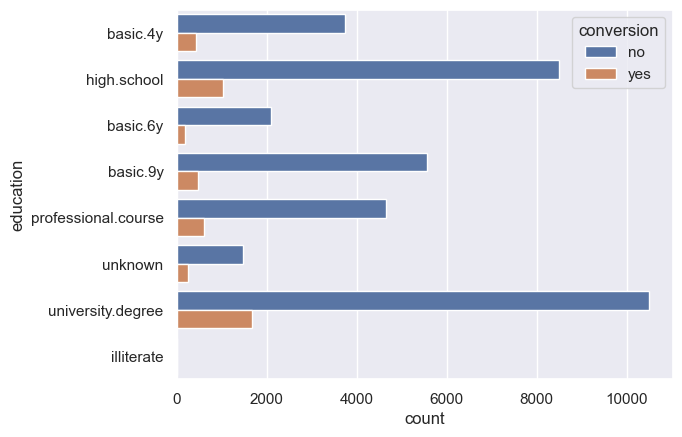

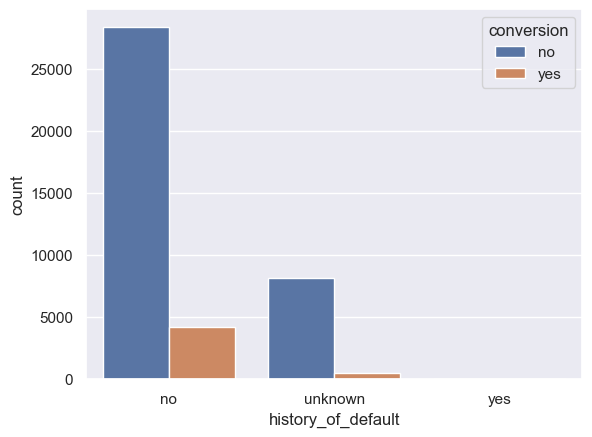

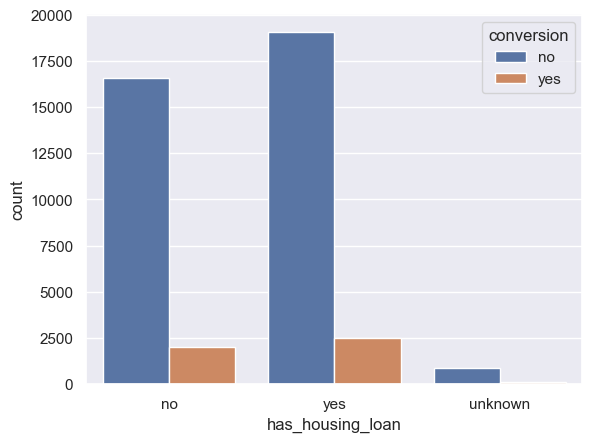

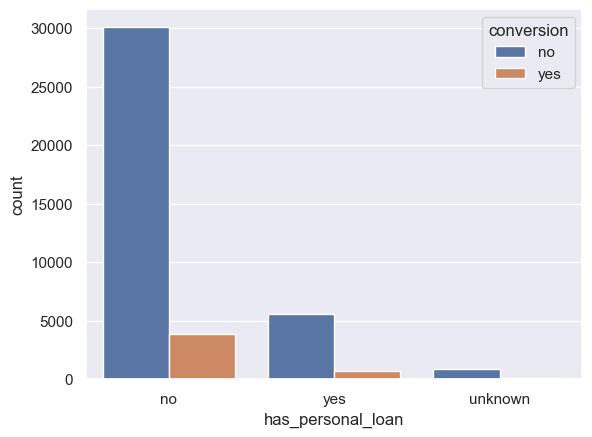

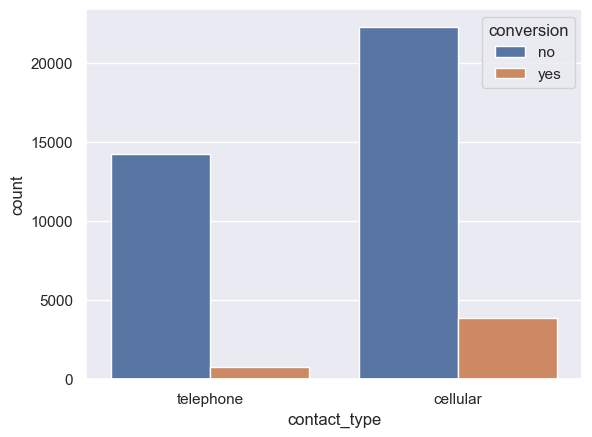

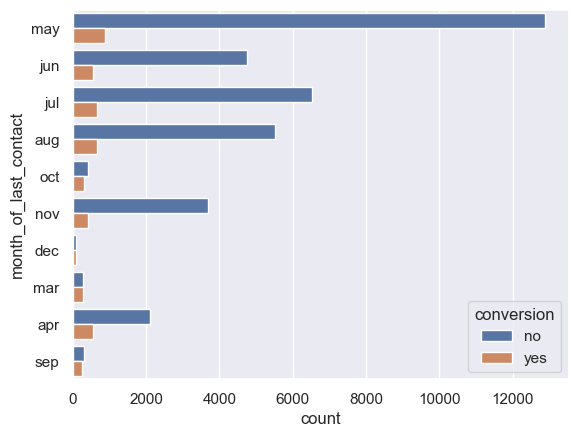

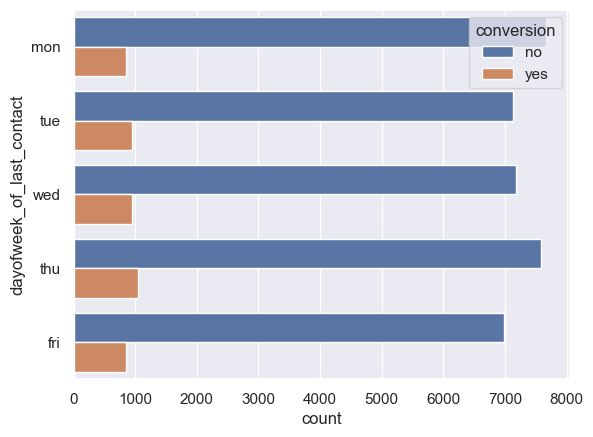

<Figure size 640x480 with 0 Axes>

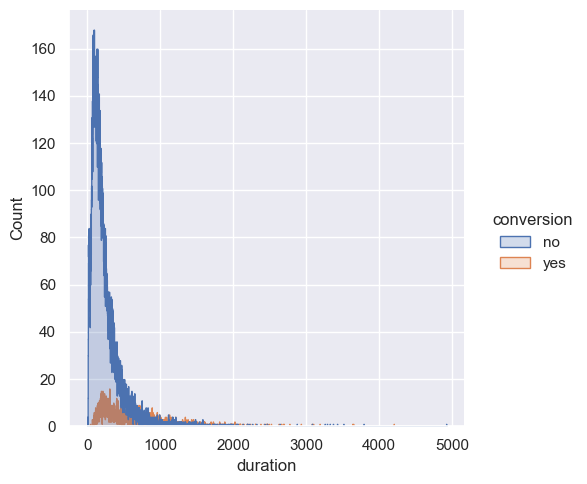

<Figure size 640x480 with 0 Axes>

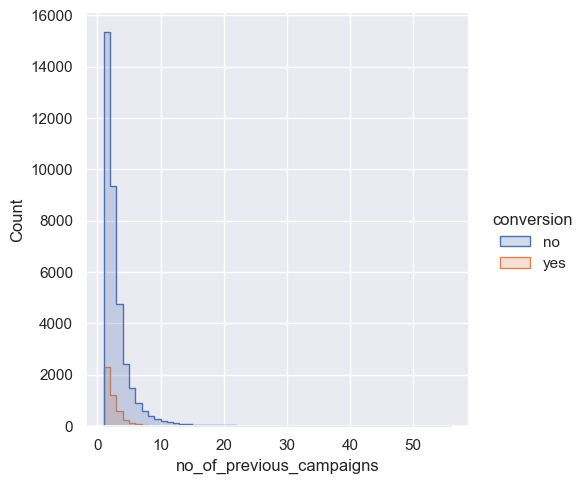

<Figure size 640x480 with 0 Axes>

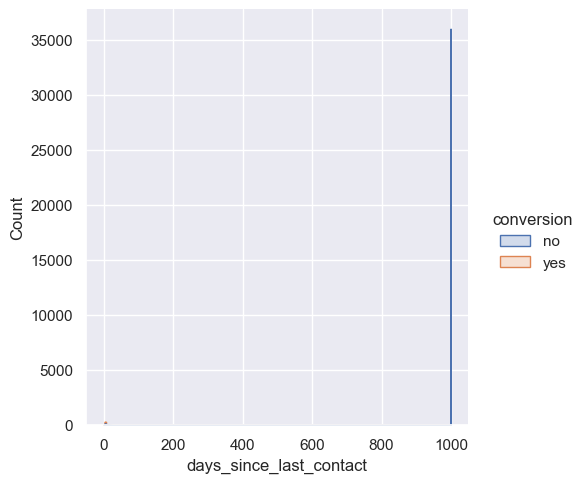

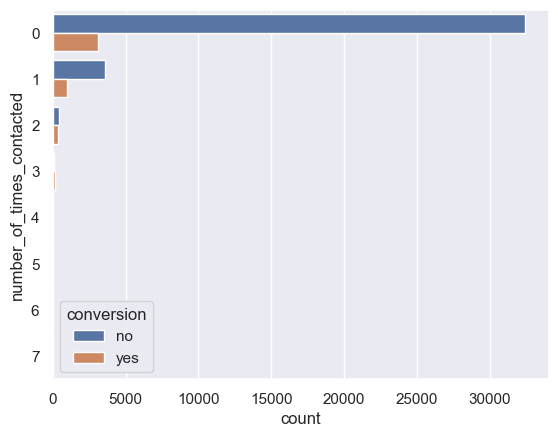

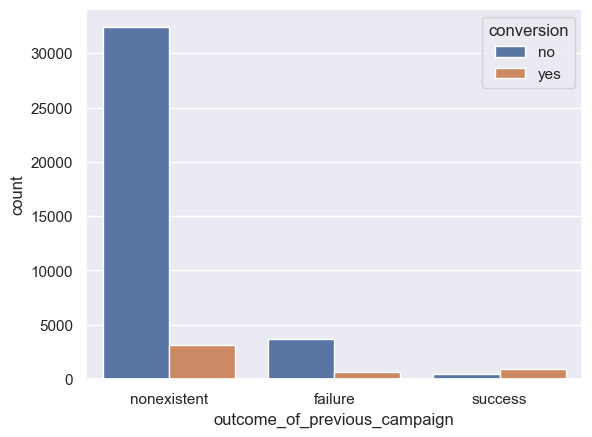

<Figure size 640x480 with 0 Axes>

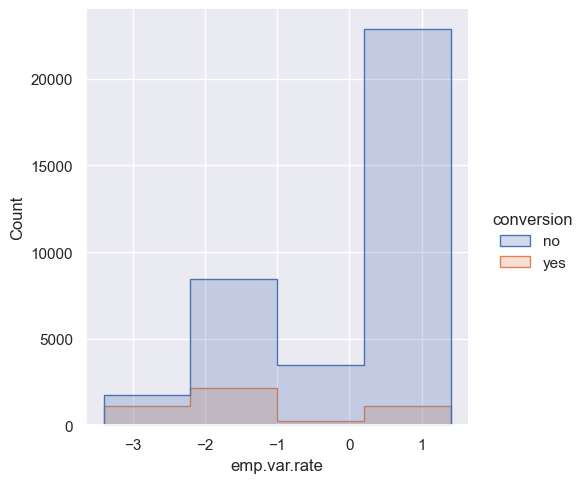

<Figure size 640x480 with 0 Axes>

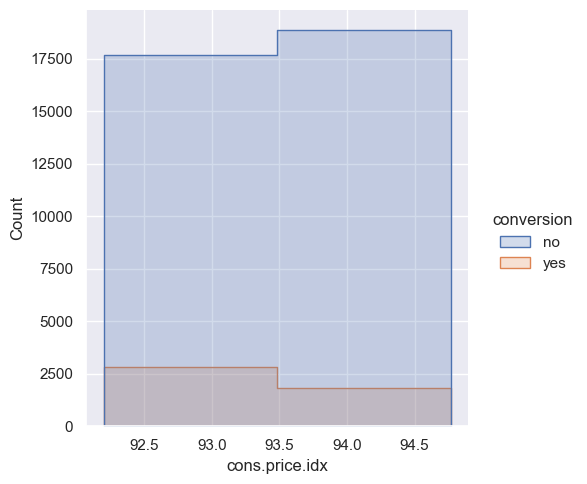

<Figure size 640x480 with 0 Axes>

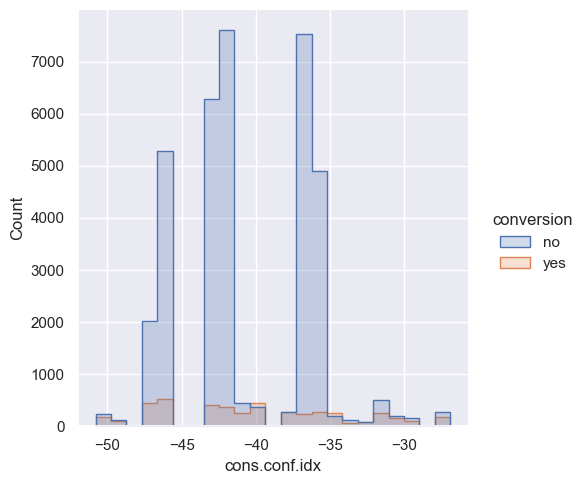

<Figure size 640x480 with 0 Axes>

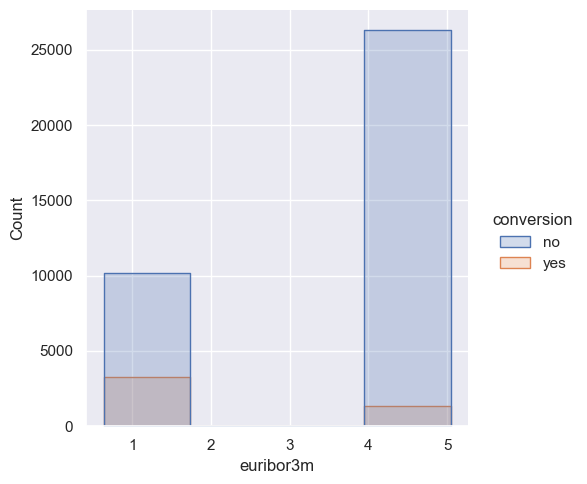

<Figure size 640x480 with 0 Axes>

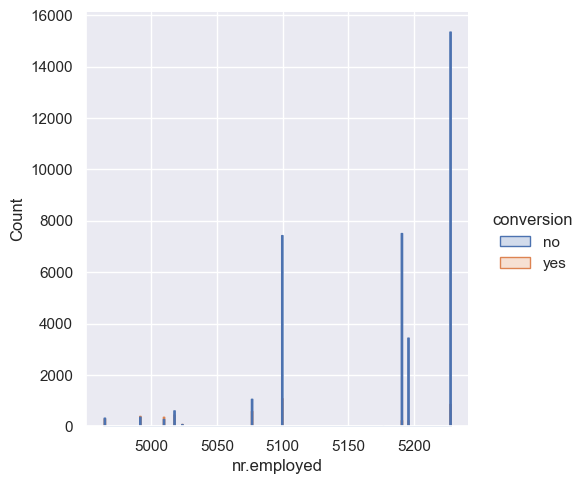

In [48]:
# --- Quick visualizations

nrows=int(len(customer_info)/2)

index=1
for i in df.drop('conversion', axis=1).columns:
    plt.figure()
    if is_numeric_dtype(df[i]):
        if len(df[i].unique()) < 10:
            sns.countplot(data=df, y=i, hue="conversion")    
        else:
            bins = int((max(df[i]) - min(df[i])))
            sns.displot(data=df, x=i, hue="conversion", bins=bins, element="step")
    elif len(df[i].unique()) > 4:
        sns.countplot(data=df, y=i, hue="conversion")
    else:    
        sns.countplot(data=df, x=i, hue="conversion")

In [49]:
df['number_of_times_contacted'].value_counts(normalize=True)

number_of_times_contacted
0    0.863431
1    0.110736
2    0.018306
3    0.005244
4    0.001700
5    0.000437
6    0.000121
7    0.000024
Name: proportion, dtype: float64

In [50]:
# --- Dropping unnecessary columns

df = df.drop(columns=['emp.var.rate', 'cons.price.idx',
                      'cons.conf.idx', 'euribor3m', 'nr.employed',
                      'days_since_last_contact'])

### Feature Engineering & Selection

In [51]:
# --- Convert target labels from 'yes', 'no' to 1, 0
df['conversion'] = df['conversion']== 'yes'
df['conversion'] = df['conversion'] * 1
df['conversion']

0        0
1        0
2        0
3        0
4        0
        ..
41183    1
41184    0
41185    0
41186    1
41187    0
Name: conversion, Length: 41188, dtype: int32

In [52]:
# --- Split model into train, test, & validation sets

X = df.drop('conversion', axis=1)
y = df['conversion']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)


# --- Check the class distribution in each set

print("------------------------------------------------")
print("Training set class distribution:")
print(y_train.value_counts())
print(y_train.value_counts(normalize=True))
print() # <- empty line for spacing

print("------------------------------------------------")
print("Validation set class distribution:")
print(y_val.value_counts())
print(y_val.value_counts(normalize=True))
print() # <- empty line for spacing

print("------------------------------------------------")
print("Testing set class distribution:")
print(y_test.value_counts())
print(y_test.value_counts(normalize=True))

------------------------------------------------
Training set class distribution:
conversion
0    25583
1     3248
Name: count, dtype: int64
conversion
0    0.887343
1    0.112657
Name: proportion, dtype: float64

------------------------------------------------
Validation set class distribution:
conversion
0    5482
1     696
Name: count, dtype: int64
conversion
0    0.887342
1    0.112658
Name: proportion, dtype: float64

------------------------------------------------
Testing set class distribution:
conversion
0    5483
1     696
Name: count, dtype: int64
conversion
0    0.88736
1    0.11264
Name: proportion, dtype: float64


In [ ]:
print(df.columns)
df.info()

In [64]:
# --- Categorical preprocessing step
 
categorical_features = ['job_category', 'marital_status', 'education', 'history_of_default', 'has_housing_loan', 'has_personal_loan', 'contact_type', 'month_of_last_contact', 'dayofweek_of_last_contact', 'number_of_times_contacted', 'outcome_of_previous_campaign']



# --- Apply one-hot encoding for categorical features
onehot_encoder = OneHotEncoder(handle_unknown='ignore')

X_train_categorical = onehot_encoder.fit_transform(X_train[categorical_features])

# --- Get the feature names (column names) using the input_features parameter
# feature_names = onehot_encoder.get_feature_names_out(categorical_features)
# print("\nFeature Names:")
# print(feature_names)

In [79]:
# --- Numerical preprocessing step

num_stdscale_features = ['age']

num_power_features = ['duration', 'no_of_previous_campaigns']

# --- Apply standard scaling for numerical_feature1
std_scaler = StandardScaler()
X_train_numerical_scaled = std_scaler.fit_transform(X_train[num_stdscale_features])

# # --- Apply min-max scaling for numerical_feature2
X_train_numerical_powertransform = power_transform(X_train[num_power_features])

In [84]:
# --- Feature selection using Recursive Feature Elimination (RFE)

# --- Combine the previously preprocessed features together
X_train_processed = np.hstack((X_train_categorical.toarray(), X_train_numerical_scaled,
                               X_train_numerical_powertransform))

# --- Create an RFE model with the logistic regression estimator
# --- Specify the number of features you want to keep (n_features_to_select)
rfe = RFE(estimator=LogisticRegression(), n_features_to_select=20)

# --- Fit the RFE model to your data
rfe.fit_transform(X_train_processed, y_train)

# --- Print the selected features
print("Selected features:")
print(rfe.support_)

# --- Print the ranking of features (1 = selected, higher numbers = less important)
print("Feature ranking:")
print(rfe.ranking_)

d:\Projects\lead_scoring\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Projects\lead_scoring\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

Selected features:
[False False False False False  True False False  True False False False
 False False False False False False False False  True False False False
  True False False False False False False False False False  True False
 False  True  True False  True  True  True  True  True False False False
 False False  True False  True  True False  True  True False  True False
  True False  True False]
Feature ranking:
[43  6  8 33 26  1 11  7  1 25 17 12 21 20 32 42 18 31 15 19  1 16 44 23
  1  9 36 30 39 29 14 45 13  4  1 22  2  1  1 38  1  1  1  1  1 40 27 28
 41 35  1 10  1  1 37  1  1  5  1  3  1 34  1 24]


In [ ]:
# --- Preprocessor for Pipeline

categorical_features = ['job_category', 'marital_status', 'education', 'history_of_default', 'has_housing_loan', 'has_personal_loan', 'contact_type', 'month_of_last_contact', 'dayofweek_of_last_contact', 'outcome_of_previous_campaign']

num_stdscale_features = ['age']

num_minmaxscale_features = ['duration', 'no_of_previous_campaigns']

preprocessor = ColumnTransformer(
    transformers=[
        ('onehote', OneHotEncoder(handle_unknown='ignore'), X_train[categorical_features]),
        ('stdscale', StandardScaler(), X_train[num_stdscale_features]),
        ('minmax', MinMaxScaler(), X_train[num_minmaxscale_features]),
    ])

### Model & Evaluation

In [86]:
# --------------------------------------------
# Logistic Regression
#

# --- Combine the previously preprocessed features together

X_train_processed = np.hstack((X_train_categorical.toarray(), X_train_numerical_scaled,
                               X_train_numerical_powertransform))

X_train_processed


logreg_model = LogisticRegression()
logreg_model.fit(X_train_processed, y_train)

d:\Projects\lead_scoring\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [92]:
logreg_model.coef_

array([[-0.0171737 , -0.37268029, -0.34046397, -0.10012568, -0.14572462,
         0.61577517, -0.34442951, -0.28827339,  0.64336952, -0.13015302,
         0.13791752,  0.08594978, -0.16245934, -0.14904437,  0.06871453,
        -0.01322299, -0.23629109, -0.09718284, -0.33309439, -0.2190093 ,
         0.78168238, -0.21888886, -0.01855512,  0.08532703,  0.20601436,
        -0.41525817, -0.04676837, -0.09982807, -0.01244358, -0.14374053,
        -0.12366025, -0.01244358, -0.11990835,  0.3790386 , -0.63505079,
        -0.18701992, -0.75168494,  0.59400446, -1.03091711, -0.03925386,
         1.66388376, -0.96984888, -0.96675933,  0.85421021,  0.57737343,
        -0.02673924, -0.13403742, -0.1062814 , -0.02132584,  0.03237172,
        -0.65556802, -0.31077323,  0.25900881,  0.26795832, -0.03877454,
         0.26012799,  0.48078469, -0.51877621, -0.89242303, -0.65556802,
         1.29197887,  0.06457416,  1.679258  , -0.10878203]])

In [ ]:
X_val

logreg_model.predict()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, roc_auc_score
)

# Split the data into train, validation, and test sets (70%, 15%, 15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print data split information
print("Data Split:")
print(f"Train data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")

# Define feature columns
categorical_features = ['categorical_feature1', 'categorical_feature2']
numerical_features = ['numerical_feature1', 'numerical_feature2']

# Split categorical and numerical features
X_train_categorical = X_train[categorical_features]
X_train_numerical = X_train[numerical_features]

# Apply one-hot encoding for categorical features
onehot_encoder = OneHotEncoder(handle_unknown='ignore')
X_train_categorical_encoded = onehot_encoder.fit_transform(X_train_categorical)

# Apply standard scaling for numerical_feature1
std_scaler = StandardScaler()
X_train_numerical_scaled = std_scaler.fit_transform(X_train_numerical)

# Apply min-max scaling for numerical_feature2
minmax_scaler = MinMaxScaler()
X_train_numerical_minmax_scaled = minmax_scaler.fit_transform(X_train_numerical_scaled)

# Concatenate transformed features
X_train_transformed = np.hstack((X_train_categorical_encoded.toarray(), X_train_numerical_minmax_scaled))

# Print preprocessing information
print("\nPreprocessing Steps:")
print("1. One-Hot Encoding for Categorical Features")
print("2. Standard Scaling for numerical_feature1")
print("3. Min-Max Scaling for numerical_feature2")

# Create a logistic regression model
logistic_regression_model = LogisticRegression()

# Apply Recursive Feature Elimination (RFE) to optimize feature selection
rfe = RFE(estimator=logistic_regression_model, n_features_to_select=5)
X_train_rfe = rfe.fit_transform(X_train_transformed, y_train)

# Print RFE information
print("\nFeature Selection (RFE):")
print("Selected the top 5 most impactful features.")

# Fit the logistic regression model to the training data
logistic_regression_model.fit(X_train_rfe, y_train)

# Make predictions on validation data

# Split categorical and numerical features for validation data
X_val_categorical = X_val[categorical_features]
X_val_numerical = X_val[numerical_features]

# Apply one-hot encoding to validation data
X_val_categorical_encoded = onehot_encoder.transform(X_val_categorical)

# Apply standard scaling to validation data for numerical_feature1
X_val_numerical_scaled = std_scaler.transform(X_val_numerical)

# Apply min-max scaling to validation data for numerical_feature2
X_val_numerical_minmax_scaled = minmax_scaler.transform(X_val_numerical_scaled)

# Concatenate transformed features for validation data
X_val_transformed = np.hstack((X_val_categorical_encoded.toarray(), X_val_numerical_minmax_scaled))

# Transform features using RFE for validation data
X_val_rfe = rfe.transform(X_val_transformed)

# Make predictions on validation data
y_val_predictions = logistic_regression_model.predict(X_val_rfe)

# Calculate and print metrics
accuracy = accuracy_score(y_val, y_val_predictions)
precision = precision_score(y_val, y_val_predictions)
recall = recall_score(y_val, y_val_predictions)
f1 = f1_score(y_val, y_val_predictions)

print("\nEvaluation Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Calculate predicted probabilities for the positive class (class 1) for validation data
y_val_probabilities = logistic_regression_model.predict_proba(X_val_rfe)[:, 1]

# Calculate ROC curve for validation data
fpr, tpr, thresholds = roc_curve(y_val, y_val_probabilities)

# Calculate AUC-ROC score for validation data
auc_roc = roc_auc_score(y_val, y_val_probabilities)

# Print ROC and AUC information
print("\nReceiver Operating Characteristic (ROC) Curve:")
print(f"AUC-ROC Score: {auc_roc:.2f}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {auc_roc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()